In [12]:
%pip install -r requirements.txt

1339.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Looking in links: /home/pinagm/dev/Udacity_DataAnalyst_NanoDegree/D502 - Capstone Project/./wheels
  Preparing metadata (setup.py) ... done
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 89.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 105.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 

In [13]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip install --upgrade " + ' '.join(packages), shell=True)

  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached tinycss2-1.4.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 5.6 MB/s eta 0:00:00a 0:00:01
Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.13.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.


0

In [23]:
import requests as req
import pandas as pd
import os
import kaggle
import glob
import subprocess
import zipfile
import  yfinance as yf
from typing import List
import beaapi as bea
from dotenv import load_dotenv
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
load_dotenv()
current_date = datetime.now().strftime('%m-%d-%Y')

In [7]:
def fetch_ssga_excel(etf: str, subfolder: str) -> str:
    """
    Fetch the SSGA Excel file for a single ETF symbol.
    
    Parameters:
    etf (str): ETF symbol in lowercase (e.g., "xli", "xlk").
    subfolder (str): Directory in which to save the downloaded file.
    
    Returns:
    str: Path to the downloaded Excel file.
    """
    url = f'https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-{etf}.xlsx'
    response = req.get(url)
    
    if response.status_code != 200:
        raise ValueError(f"Failed to download {etf}. HTTP status code: {response.status_code}")
    
    current_date = datetime.now().strftime('%m-%d-%Y')
    file_path = os.path.join(subfolder, f'{etf}-{current_date}.xlsx')
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    
    return file_path

def process_ssga_excel(file_path: str) -> pd.DataFrame:
    """
    Reads the ETF Excel file from SSGA, trims disclaimers, removes empty lines, and returns a DataFrame.

    Parameters:
    file_path (str): Local path to the downloaded Excel file.

    Returns:
    pd.DataFrame: Processed SSGA holdings data with columns [Name, Ticker, Identifier, SEDOL, Weight, Sector, ...].
    """
    # The file has disclaimers in the last rows, skiprows=4 means we skip the top disclaimers
    # usecols="A:H" to read only the first 8 columns
    df = pd.read_excel(file_path, skiprows=4, header=0, usecols="A:H")
    
    # If the disclaimers line is found, slice the DataFrame up to that row
    disclaimers_str = (
        "Past performance is not a reliable indicator of future performance. "
        "Investment return and principal value will fluctuate, so you may have a gain or loss when shares are sold. "
        "Current performance may be higher or lower than that quoted. All results are historical and assume the "
        "reinvestment of dividends and capital gains. Visit www.ssga.com for most recent month-end performance. "
    )
    drop_index = df[df['Name'] == disclaimers_str].index
    if not drop_index.empty:
        df = df[:drop_index[0]]
    
    # Remove last row if it's entirely NaN
    if not df.empty and df.iloc[-1].isna().all():
        df = df[:-1]
    
    return df

def fetch_and_process_etf_data(etf_list):
    """
    Download and parse SSGA Excel holdings for a list of ETF tickers.
    
    Parameters:
    etf_list (List[str]): e.g. ['XLI', 'XLK', 'XLE', 'XLB'] (uppercase or mixed case).
    
    Returns:
    List[pd.DataFrame]: A list of DataFrames, one for each ETF, in the same order as etf_list.
    """
    subfolder = 'SSGA Data'
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

    ssga_df_list = []
    
    for etf_symbol in etf_list:
        etf_lower = etf_symbol.lower()
        # 1) Download the Excel
        file_path = fetch_ssga_excel(etf_lower, subfolder)
        # 2) Process / clean up the DataFrame
        df = process_ssga_excel(file_path)
        # (Optional) Attach a column for the ETF symbol
        df['ETF'] = etf_symbol.upper()
        ssga_df_list.append(df)

    return ssga_df_list

# --- Usage Example ---
etf_list = ['XLI', 'XLK', 'XLE', 'XLB']
ssga_df_list = fetch_and_process_etf_data(etf_list)

# Print tails to verify we have data for each
for idx, df in enumerate(ssga_df_list, start=1):
    print(f"\n=== SSGA DataFrame #{idx} (ETF: {etf_list[idx-1]}) ===")
    print(df.tail())



=== SSGA DataFrame #1 (ETF: XLI) ===
                             Name  Ticker Identifier    SEDOL    Weight  \
76           GENERAC HOLDINGS INC    GNRC  368736104  B6197Q2  0.191436   
77   HUNTINGTON INGALLS INDUSTRIE     HII  446413106  B40SSC9  0.189948   
78  SSI US GOV MONEY MARKET CLASS       -  924QSGII3        -  0.036654   
79                      US DOLLAR       -  999USDZ92        -  0.008719   
80        XAI EMINI INDUSTR MAR25  AIXH25  ADI2SGVK5        - -0.005027   

   Sector  Shares Held Local Currency  ETF  
76      -    297993.00            USD  XLI  
77      -    197188.00            USD  XLI  
78      -   7497251.15            USD  XLI  
79      -   1783345.65            USD  XLI  
80      -     25800.00            USD  XLI  

=== SSGA DataFrame #2 (ETF: XLK) ===
                             Name  Ticker Identifier    SEDOL    Weight  \
68             ENPHASE ENERGY INC    ENPH  29355A107  B65SQW4  0.102101   
69  SSI US GOV MONEY MARKET CLASS       -  924QSGII3 

In [8]:
def fetch_bea_json(api_key: str, years: str) -> dict:
    """
    Fetches GDP by Industry data from the BEA API in JSON format.

    Parameters:
    -----------
    api_key : str
        Your BEA API key.
    years : str
        A comma-separated string of years (e.g., "2020,2021,2022,2023,2024").

    Returns:
    --------
    dict
        Parsed JSON response from the BEA API, or None if an error occurred.
    """
    base_url = "https://apps.bea.gov/api/data/"
    params = {
        "UserID": api_key,
        "method": "GetData",
        "datasetname": "GDPbyIndustry",
        "Frequency": "Q",
        "Year": years,
        "Industry": "ALL",
        "TableID": "ALL",
        "ResultFormat": "JSON"
    }
    try:
        response = req.get(base_url, params=params)
        response.raise_for_status()  # raises HTTPError if status != 200
        data = response.json()
        
        # Check for error key in the response
        if 'Error' in data.get('BEAAPI', {}):
            err = data['BEAAPI']['Error']
            print(f"API request failed with code {err['APIErrorCode']}: {err['APIErrorDescription']}")
            return None
        
        return data
    except req.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return None

def process_bea_json(raw_data: dict) -> pd.DataFrame:
    """
    Parses the raw JSON from BEA into a pivoted DataFrame, excluding certain irrelevant rows.

    Parameters:
    -----------
    raw_data : dict
        The JSON dictionary returned by fetch_bea_json.

    Returns:
    --------
    pd.DataFrame
        A pivoted DataFrame with columns for YearQuarter, and rows for each Industry/IndustryDescription.
        Certain 'unwanted' industry descriptions are filtered out.
        Returns None if the data is missing or invalid.
    """
    if not raw_data or 'BEAAPI' not in raw_data or 'Results' not in raw_data['BEAAPI']:
        print("Error: 'Results' key not found in the API response.")
        return None

    results = raw_data['BEAAPI']['Results']
    df_results = pd.DataFrame(results)
    if df_results.empty or 'Data' not in df_results.columns:
        print("Error: No 'Data' found in the Results.")
        return None

    # 'Data' itself is often a list of dictionaries
    nested_data = df_results.loc[0, "Data"]
    bea_df = pd.DataFrame(nested_data)
    
    # Fix possible typos in the column name
    if "IndustrYDescription" in bea_df.columns:
        bea_df.rename(columns={"IndustrYDescription": "IndustryDescription"}, inplace=True)

    # Convert DataValue to float
    bea_df['DataValue'] = bea_df['DataValue'].astype(float, errors='raise')

    # Create a YearQuarter column to pivot on
    bea_df['YearQuarter'] = bea_df['Year'].astype(str) + 'Q' + bea_df['Quarter']

    # Pivot: index by (Industry, IndustryDescription), columns=YearQuarter, values=DataValue
    pivot_df = bea_df.pivot_table(
        index=['Industry', 'IndustryDescription'],
        columns='YearQuarter',
        values='DataValue',
        aggfunc='sum'
    ).reset_index()

    # Filter out unwanted industry descriptions
    excluded_industries = [
        "Taxes on production and imports less subsidies",
        "Energy inputs",
        "Intermediate inputs",
        "Materials inputs",
        "Purchased-services inputs",
        "Value added",
        "Compensation of employees",
        "Gross operating surplus"
    ]
    filtered_df = pivot_df[~pivot_df['IndustryDescription'].isin(excluded_industries)]

    return filtered_df

def save_bea_raw_data(df: pd.DataFrame, folder: str = 'BEA Data') -> str:
    """
    Saves the DataFrame to an Excel file with a timestamp-based filename.

    Parameters:
    -----------
    df : pd.DataFrame
        The pivoted and filtered DataFrame from process_bea_json.
    folder : str
        Destination folder name.

    Returns:
    --------
    str : Path to the saved Excel file.
    """
    os.makedirs(folder, exist_ok=True)
    current_date = datetime.now().strftime('%m-%d-%Y')
    file_path = os.path.join(folder, f"bea-gdp-by-industry-raw-{current_date}.xlsx")
    df.to_excel(file_path, index=False)
    return file_path

def map_sectors(df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps each IndustryDescription to a top-level sector (Technology, Materials, Energy, Industrials),
    returning only rows in those focus sectors.

    Parameters:
    -----------
    df : pd.DataFrame
        Pivoted DataFrame with columns [Industry, IndustryDescription, ...quarter columns... ].

    Returns:
    --------
    pd.DataFrame
        A copy of df with a new 'Sector' column. Rows outside the focus sectors are excluded.
    """
    sector_map = {
        "Technology": [
            "Computer and electronic products",
            "Computer systems design and related services",
            "Data processing, internet publishing, and other information services",
            "Information-communications-technology-producing industries"
        ],
        "Materials": [
            "Agriculture, forestry, fishing, and hunting",
            "Farms",
            "Forestry, fishing, and related activities",
            "Mining",
            "Mining, except oil and gas",
            "Support activities for mining",
            "Wood products",
            "Paper products",
            "Chemical products",
            "Plastics and rubber products",
            "Nonmetallic mineral products",
            "Primary metals",
            "Fabricated metal products"
        ],
        "Energy": [
            "Oil and gas extraction",
            "Petroleum and coal products",
            "Pipeline transportation"
        ],
        "Industrials": [
            "Construction",
            "Machinery",
            "Electrical equipment, appliances, and components",
            "Other transportation equipment",
            "Miscellaneous manufacturing",
            "Durable goods",
            "Wholesale trade",
            "Rail transportation",
            "Water transportation",
            "Truck transportation",
            "Transit and ground passenger transportation",
            "Other transportation and support activities",
            "Transportation and warehousing",
            "Warehousing and storage",
            "Waste management and remediation services"
        ]
    }

    # Helper to assign a top-level sector
    def get_sector(description: str) -> str:
        for sector, cat_list in sector_map.items():
            if description in cat_list:
                return sector
        return "Other"

    df_copy = df.copy()
    df_copy["Sector"] = df_copy["IndustryDescription"].apply(get_sector)

    focus_sectors = ["Technology", "Materials", "Energy", "Industrials"]
    df_filtered = df_copy[df_copy["Sector"].isin(focus_sectors)]
    return df_filtered

def fetch_bea_gdp_by_industry(api_key: str, years: str) -> pd.DataFrame:
    """
    High-level orchestrator that fetches BEA data, processes it, saves a raw Excel,
    maps top-level sectors, and saves a final filtered Excel.

    Parameters:
    -----------
    api_key : str
        Your BEA API key.
    years : str
        Comma-separated years (e.g. "2020,2021,2022,2023,2024").

    Returns:
    --------
    pd.DataFrame
        The final DataFrame with top-level sectors included.
    """
    raw_json = fetch_bea_json(api_key, years)
    if raw_json is None:
        return None
    
    pivoted_df = process_bea_json(raw_json)
    if pivoted_df is None:
        print("Error: Could not process BEA data into pivoted DataFrame.")
        return None

    # Save the pivoted "raw" data
    _ = save_bea_raw_data(pivoted_df)  # optional to keep the file path

    # Map each IndustryDescription to a top-level sector
    final_df = map_sectors(pivoted_df)

    # Save a separate 'filtered' file
    subfolder = 'BEA Data'
    current_date = datetime.now().strftime('%m-%d-%Y')
    filtered_path = os.path.join(subfolder, f"bea-gdp-by-industry-filtered-{current_date}.xlsx")
    final_df.to_excel(filtered_path, index=False)

    return final_df


# ------------------ Usage Example -------------------
if __name__ == "__main__":
    import os
    
    api_key = os.environ.get("beakey")  # or your key as a string
    years = "2020,2021,2022,2023,2024"
    
    bea_df = fetch_bea_gdp_by_industry(api_key, years)
    if bea_df is not None:
        print(bea_df.tail())
    else:
        print("BEA GDP data retrieval or processing failed.")


YearQuarter Industry                                IndustryDescription  \
43              48TW                     Transportation and warehousing   
44               493                            Warehousing and storage   
50               514  Data processing, internet publishing, and othe...   
62              5415       Computer systems design and related services   
66               562          Waste management and remediation services   

YearQuarter    2020QI   2020QII  2020QIII   2020QIV    2021QI   2021QII  \
43           5959.009  4382.610  5399.989  5646.258  5795.131  6118.576   
44           1125.151  1037.465  1346.907  1269.619  1350.713  1274.375   
50           2790.249  2701.492  3137.504  3289.488  3402.355  3571.411   
62           2973.620  2856.763  2841.172  3072.813  3167.013  3281.216   
66           1166.495   993.554  1209.515  1198.336  1187.525  1187.900   

YearQuarter  2021QIII   2021QIV  ...  2022QIII   2022QIV    2023QI   2023QII  \
43           6429.

In [16]:
def setup_kaggle_data():
    # Step 1: Ensure the "Kaggle Data" directory exists
    kaggle_data_dir = "Kaggle Data"
    os.makedirs(kaggle_data_dir, exist_ok=True)
    
    # Step 2: Check if the .csv file already exists
    csv_exists = any(filename.endswith('.csv') for filename in os.listdir(kaggle_data_dir))
    
    if not csv_exists:
        # Step 3: Download the dataset using the Kaggle CLI
        dataset = "jakewright/9000-tickers-of-stock-market-data-full-history"
        subprocess.run(["kaggle", "datasets", "download", "-d", dataset])
        
        # Step 4: Unzip the downloaded file
        zip_filename = dataset.split('/')[-1] + ".zip"
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(kaggle_data_dir)
        
        # Step 5: Remove any files in the "Kaggle Data" directory that are not .csv files
        for filename in os.listdir(kaggle_data_dir):
            if not filename.endswith('.csv'):
                os.remove(os.path.join(kaggle_data_dir, filename))
        
        # Optionally, remove the downloaded zip file
        os.remove(zip_filename)

# Call the function
setup_kaggle_data()

# Load the CSV file into a DataFrame
kag_df = pd.read_csv('Kaggle Data/all_stock_data.csv')

# Convert the 'Date' column to datetime format
kag_df['Date'] = pd.to_datetime(kag_df['Date'])

# Filter the DataFrame for dates between 2020-01-01 and 2023-12-31
start_date = '2020-01-01'
end_date = '2023-12-31'
filtered_kag_df = kag_df[(kag_df['Date'] >= start_date) & (kag_df['Date'] <= end_date)]

# Display the first few rows of the filtered DataFrame
filtered_kag_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
24919429,2020-01-02,HOFV,232.320007,232.539993,231.660004,231.660004,11459.0,0.0,0.0
24919430,2020-01-02,CTSH,61.055629,61.222259,60.457717,60.692959,2234500.0,0.0,0.0
24919431,2020-01-02,AZUL,43.610001,44.080002,43.150002,43.590000,532300.0,0.0,0.0
24919432,2020-01-02,FNCTF,12.707134,12.707134,12.707134,12.707134,100.0,0.0,0.0
24919433,2020-01-02,BLE,13.720488,13.720488,13.621064,13.657218,54700.0,0.0,0.0


In [17]:
filtered_kag_df.tail()

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
32724160,2023-12-29,RTO,28.459999,28.620001,28.260000,28.610001,620800.0,0.0,0.0
32724161,2023-12-29,SHZNY,41.020000,41.020000,41.020000,41.020000,0.0,0.0,0.0
32724162,2023-12-29,ONMD,0.745000,0.900000,0.745000,0.810000,70100.0,0.0,0.0
32724163,2023-12-29,KMPR,48.349998,49.150002,48.150002,48.669998,312300.0,0.0,0.0
32724164,2023-12-29,SBT,5.850000,5.870000,5.770000,5.770000,14200.0,0.0,0.0


In [18]:
import os
from typing import List
import pandas as pd
import yfinance as yf

def ensure_directory_exists(directory: str) -> None:
    """
    Ensure the specified directory exists, creating it if necessary.

    Parameters
    ----------
    directory : str
        The path of the directory to check or create.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")
    else:
        print(f"Directory '{directory}' already exists.")

def download_data(tickers: List[str], start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Download historical stock data for multiple tickers using yfinance.

    Parameters
    ----------
    tickers : List[str]
        A list of ticker symbols (e.g. ["XLI","XLK","XLE"]).
    start_date : str
        Start date in "YYYY-MM-DD" format.
    end_date : str
        End date in "YYYY-MM-DD" format.
    interval : str
        Data interval (e.g., "1d","1wk","1mo","3mo"). Defaults to "1d".

    Returns
    -------
    pd.DataFrame
        A multi-index DataFrame with columns as (Ticker, Field).
        By default, yfinance includes columns like "Open","High","Low","Close","Volume".
    """
    return yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval=interval,
        group_by="ticker",
        auto_adjust=True,
        threads=True,
        progress=True
    )

def filter_columns(df: pd.DataFrame, tickers: List[str], fields: List[str]) -> pd.DataFrame:
    """
    Select specific columns (fields) for each ticker from a multi-index DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The multi-index DataFrame returned by download_data.
    tickers : List[str]
        The list of tickers to keep columns for.
    fields : List[str]
        The list of fields to keep for each ticker (e.g. ["High","Low"]).

    Returns
    -------
    pd.DataFrame
        A subset of the original DataFrame containing only the specified (Ticker, Field) columns.
    """
    # Build a list of valid (Ticker, Field) column tuples
    keep_cols = [(t, f) for t in tickers for f in fields if (t, f) in df.columns]
    return df[keep_cols].copy()

def add_change_columns(df: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    """
    Add a "Change" column for each ticker, computed as (High - Low).

    Parameters
    ----------
    df : pd.DataFrame
        A multi-index DataFrame with columns like (Ticker, "High"), (Ticker, "Low").
    tickers : List[str]
        List of tickers to process.

    Returns
    -------
    pd.DataFrame
        Modified DataFrame with additional (Ticker, "Change") columns for each ticker having "High" and "Low".
    """
    for t in tickers:
        if (t, "High") in df.columns and (t, "Low") in df.columns:
            df[(t, "Change")] = df[(t, "High")] - df[(t, "Low")]
    return df

def process_change_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Restructure 'Change' columns from a multi-index to a single-level index.

    This extracts all (Ticker, "Change") columns, flattens them to 'Ticker_Change' columns,
    and resets the index so there is a single 'Date' column instead of the multi-index.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns like (Ticker, "Change").

    Returns
    -------
    pd.DataFrame
        A new DataFrame with each ticker's change in a single column named 'Ticker_Change',
        plus a 'Date' column (extracted from the index).
    """
    # Filter just the "Change" columns
    df_only_change = df.loc[:, (slice(None), "Change")].copy()  # multi-index slice
    # Remove the second level from column names
    df_only_change.columns = df_only_change.columns.droplevel(1)
    # Rename columns => Ticker_Change
    df_only_change.columns = [f"{ticker}_Change" for ticker in df_only_change.columns]
    df_only_change.reset_index(inplace=True)
    
    # If the resulting index column is named "index", rename it to "Date"
    if df_only_change.columns[0] == "index":
        df_only_change.rename(columns={"index": "Date"}, inplace=True)
    return df_only_change

def save_to_csv(df: pd.DataFrame, path: str) -> None:
    """
    Save a DataFrame to CSV with no index, and print confirmation.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to save.
    path : str
        Output CSV file path.
    """
    df.to_csv(path, index=False)
    print(f"Data with only 'Change' columns saved to: {path}")

# ---------------------------
# Sample Orchestrator Usage
# ---------------------------
if __name__ == "__main__":
    data_dir = "Yahoo Data"
    ensure_directory_exists(data_dir)

    tickers = ["XLI", "XLK", "XLE", "XLB"]
    # 1) Download data from yfinance
    df_full = download_data(tickers, start_date="2020-01-01", end_date="2024-01-01", interval="3mo")
    
    # 2) Filter columns to just 'High' and 'Low'
    df_filtered = filter_columns(df_full, tickers, ["High", "Low"])
    
    # 3) Add (Ticker,"Change") columns
    df_filtered = add_change_columns(df_filtered, tickers)
    
    # 4) Extract only the "Change" columns into a single-level DataFrame
    df_only_change = process_change_columns(df_filtered)
    
    # 5) Save the final result
    csv_path = os.path.join(data_dir, "sector_quarterly_only_change.csv")
    save_to_csv(df_only_change, csv_path)

    print(df_only_change.head())


Directory 'Yahoo Data' created.


[*********************100%***********************]  4 of 4 completed

Data with only 'Change' columns saved to: Yahoo Data/sector_quarterly_only_change.csv
        Date  XLI_Change  XLK_Change  XLE_Change  XLB_Change
0 2020-01-01   34.623137   33.295936   30.822577   21.908647
1 2020-04-01   19.467892   28.695260   16.112839   16.252515
2 2020-07-01   12.474148   23.360485    8.296763   10.461686
3 2020-10-01   14.514659   21.075826   12.746973   10.079117
4 2021-01-01   13.851599   14.060704   14.423069    9.381534


In [19]:
import glob
import pandas as pd
from datetime import datetime
import os

def extract_top_tickers_from_ssga(
    folder_path: str,
    n: int = 10,
    skiprows: int = 4,
    weight_col: str = "Weight",
    ticker_col: str = "Ticker"
) -> list:
    """
    Read all SSGA Excel files in a folder, extract the top n tickers by weight, and return a unique list of them.

    Parameters
    ----------
    folder_path : str
        Path to the folder containing .xlsx files from SSGA.
    n : int
        Number of top holdings to extract per file. Default is 10.
    skiprows : int
        Rows to skip at the top when reading the Excel. Default 4 based on your file format.
    weight_col : str
        Column name for weight in the Excel file. Default is "Weight".
    ticker_col : str
        Column name for ticker in the Excel file. Default is "Ticker".

    Returns
    -------
    List[str]
        A unique list of top ticker symbols across all SSGA Excel files in the folder.
    """
    ssga_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
    top_tickers = []

    for file in ssga_files:
        df = pd.read_excel(file, skiprows=skiprows)
        # Grab top n rows by weight, extract ticker col
        top_n = df.nlargest(n, weight_col)[ticker_col].tolist()
        top_tickers.extend(top_n)

    # Deduplicate
    return list(set(top_tickers))

def filter_kaggle_dataframe_by_tickers(
    df: pd.DataFrame,
    tickers: list,
    date_col: str = "Date",
    start_date: str = "2020-01-01",
    end_date: str = "2023-12-31"
) -> pd.DataFrame:
    """
    Filter a Kaggle-based DataFrame for the given tickers and a date range, returning a new DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing stock records (with a 'Ticker' column).
    tickers : list
        List of tickers to keep.
    date_col : str
        Name of the column holding dates. Default "Date".
    start_date : str
        Earliest date in "YYYY-MM-DD" format. Default "2020-01-01".
    end_date : str
        Latest date in "YYYY-MM-DD" format. Default "2023-12-31".

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with rows only for the specified tickers and date range.
        'Date' column is converted to datetime.
    """
    # Keep only rows that match top tickers
    df_filtered = df[df['Ticker'].isin(tickers)].copy()

    # Ensure date_col is datetime, then filter by date range
    df_filtered[date_col] = pd.to_datetime(df_filtered[date_col], errors='coerce')
    mask = (df_filtered[date_col] >= start_date) & (df_filtered[date_col] <= end_date)
    df_filtered = df_filtered[mask]

    return df_filtered

def resample_to_quarterly(
    df: pd.DataFrame,
    date_col: str = "Date",
    agg_dict: dict = None
) -> pd.DataFrame:
    """
    Resample a DataFrame (with Ticker & a date index) to quarterly frequency using the specified aggregations.

    Parameters
    ----------
    df : pd.DataFrame
        Stock DataFrame with columns including 'Ticker', 'Open','High','Low','Close','Volume','Dividends','Stock Splits'.
    date_col : str
        The column that will become the index for resampling. Default "Date".
    agg_dict : dict
        A dict mapping column -> aggregation function(s). If None is provided,
        a default is used for typical OHLC resampling.

    Returns
    -------
    pd.DataFrame
        Resampled DataFrame, grouped by Ticker, then aggregated quarterly, then reset to a normal index.
    """
    if agg_dict is None:
        agg_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum',
            'Dividends': 'sum',
            'Stock Splits': 'sum'
        }

    # Set the date_col as index, group by Ticker, then resample
    df_copy = df.copy()
    df_copy.set_index(date_col, inplace=True)
    # groupby Ticker, resample quarterly
    quarterly_df = (df_copy.groupby('Ticker')
                            .resample('Q')
                            .agg(agg_dict)
                            .reset_index())
    return quarterly_df

# --------------------------------------------------------------------
# Usage Example
# --------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Extract top 10 tickers from SSGA Excel files
    folder_path = "/home/pinagm/dev/Udacity_DataAnalyst_NanoDegree/D502 - Capstone Project/SSGA Data"
    top_tickers = extract_top_tickers_from_ssga(folder_path, n=10)
    print(f"Top tickers from SSGA: {top_tickers}")

    # 2) Filter an existing Kaggle-based DataFrame with top_tickers & date range
    # Suppose 'filtered_kag_df' is a DataFrame from earlier steps
    # Example: read from a CSV if you have it saved
    filtered_kag_df = pd.read_csv("Kaggle Data/all_stock_data.csv")  # or your DataFrame

    df_top = filter_kaggle_dataframe_by_tickers(
        filtered_kag_df,
        top_tickers,
        date_col="Date",
        start_date="2020-01-01",
        end_date="2023-12-31"
    )

    # 3) Resample that filtered DataFrame to quarterly frequency
    quarterly_kag_df = resample_to_quarterly(df_top)

    # 4) Preview & save the quarterly DataFrame
    print(quarterly_kag_df.head())
    output_path = "/home/pinagm/dev/Udacity_DataAnalyst_NanoDegree/D502 - Capstone Project/Kaggle Data/filtered_stock_data_quarterly.csv"
    quarterly_kag_df.to_csv(output_path, index=False)
    print(f"Quarterly data saved to {output_path}")


Top tickers from SSGA: ['COP', 'ETN', 'BA', 'ACN', 'DD', 'LIN', 'AAPL', 'VMC', 'AVGO', 'APD', 'ECL', 'ORCL', 'NEM', 'CTVA', 'SHW', 'ADBE', 'NVDA', 'CAT', 'UNP', 'HON', 'IBM', 'RTX', 'ADP', 'CRM', 'NUE', 'XOM', 'MPC', 'GE', 'DE', 'WMB', 'OKE', 'SLB', 'MSFT', 'PSX', 'UBER', 'CSCO', 'EOG', 'KMI', 'FCX', 'CVX']
  Ticker       Date        Open        High         Low       Close  \
0   AAPL 2020-03-31   73.192005   81.038115   52.654220   62.976532   
1   AAPL 2020-06-30   61.047293   92.471916   58.669790   90.589600   
2   AAPL 2020-09-30   90.669063  137.303621   88.548348  115.242294   
3   AAPL 2020-12-31  117.063323  138.347911  106.793920  132.267349   
4   AAPL 2021-03-31  133.094712  144.627854  116.012942  121.942871   

         Volume  Dividends  Stock Splits  
0  1.223372e+10     0.1925           0.0  
1  9.314611e+09     0.2050           0.0  
2  1.097559e+10     0.2050           4.0  
3  7.339933e+09     0.2050           0.0  
4  6.724536e+09     0.2050           0.0  
Quarte

In [21]:
import os
import pandas as pd

def load_excel_if_exists(filepath: str) -> pd.DataFrame:
    """
    If the specified Excel file exists, read it into a DataFrame and print its head.
    Otherwise, print a 'File not found' message and return None.
    
    Parameters
    ----------
    filepath : str
        Path to the Excel file.
    
    Returns
    -------
    pd.DataFrame or None
        The loaded DataFrame, or None if the file does not exist.
    """
    if os.path.exists(filepath):
        df = pd.read_excel(filepath)
        print(f"Loaded Excel file: {filepath}")
        print(df.head())
        return df
    else:
        print(f"File not found: {filepath}")
        return None

def load_csv_if_exists(filepath: str) -> pd.DataFrame:
    """
    If the specified CSV file exists, read it into a DataFrame and print its head.
    Otherwise, print a 'File not found' message and return None.
    
    Parameters
    ----------
    filepath : str
        Path to the CSV file.
    
    Returns
    -------
    pd.DataFrame or None
        The loaded DataFrame, or None if the file does not exist.
    """
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        print(f"Loaded CSV file: {filepath}")
        print(df.head())
        return df
    else:
        print(f"File not found: {filepath}")
        return None

# ------------------------------
# Usage Example
# ------------------------------
if __name__ == "__main__":
    current_date = datetime.now().strftime('%m-%d-%Y')
    bea_excel = f'BEA Data/bea-gdp-by-industry-filtered-{current_date}.xlsx'
    kag_csv = 'Kaggle Data/filtered_stock_data_quarterly.csv'
    
    bea_excel_df = load_excel_if_exists(bea_excel)
    kag_csv_df = load_csv_if_exists(kag_csv)

    # Now you can check if they are None or proceed if they're valid DataFrames
    if bea_excel_df is not None:
        # do something with bea_excel_df
        pass
    if kag_csv_df is not None:
        # do something with kag_csv_df
        pass


Loaded Excel file: BEA Data/bea-gdp-by-industry-filtered-03-11-2025.xlsx
  Industry                          IndustryDescription    2020QI   2020QII  \
0       11  Agriculture, forestry, fishing, and hunting  2441.610  2126.918   
1    111CA                                        Farms  2211.313  1909.135   
2    113FF    Forestry, fishing, and related activities   781.368   759.700   
3       21                                       Mining  2650.141  1637.385   
4      211                       Oil and gas extraction  1697.653  1088.254   

   2020QIII   2020QIV    2021QI   2021QII  2021QIII   2021QIV  ...  2022QIII  \
0  2535.020  2592.121  2568.646  2840.182  2732.267  2683.640  ...  2962.575   
1  2348.416  2360.465  2368.935  2637.372  2495.972  2444.318  ...  2724.594   
2   857.438   991.167  1038.892   943.554   927.734   861.779  ...   963.665   
3  2495.354  2493.640  2874.500  3151.607  3092.183  3554.839  ...  3930.475   
4  3174.931  2061.840  2511.923  2765.309  2549.100 

In [25]:
import os
import glob
import re
import pandas as pd

# --------------- HELPER FUNCTIONS ---------------

roman_map = {'I': '1', 'II': '2', 'III': '3', 'IV': '4'}

def parse_quarter_str(qstr: str) -> pd.Timestamp:
    """
    Convert strings like '2020QI' or '2021QIII' into the end-of-quarter date:
    e.g. '2020-03-31'.

    Returns a pd.Timestamp, or None if format is invalid.
    """
    match = re.match(r"^(\d{4})Q(I|II|III|IV)$", qstr)
    if match:
        year_str = match.group(1)           # e.g. '2020'
        roman_quarter = match.group(2)      # e.g. 'II'
        year = int(year_str)
        quarter_num = int(roman_map[roman_quarter])  # 1..4
        period = pd.Period(year=year, quarter=quarter_num, freq='Q')
        return period.end_time
    else:
        return None

def melt_bea_quarters(
    df: pd.DataFrame,
    id_cols: list = ["Industry","IndustryDescription","Sector"]
) -> pd.DataFrame:
    """
    Melt a wide BEA DataFrame with quarter columns (e.g., '2020QI','2020QII',...)
    into a long format, creating a 'QuarterEnd' column for each quarter.
    """
    # Identify quarter columns that contain 'Q' but aren't in id_cols
    quarter_cols = [
        c for c in df.columns
        if c not in id_cols
        and 'Q' in c
    ]

    # Melt from wide to long
    melted = df.melt(
        id_vars=id_cols,
        value_vars=quarter_cols,
        var_name='QuarterStr',
        value_name='GDP'
    )

    # Convert QuarterStr to a real end-of-quarter date
    melted['QuarterEnd'] = melted['QuarterStr'].apply(parse_quarter_str)

    # Drop rows with invalid QuarterStr
    melted.dropna(subset=['QuarterEnd'], inplace=True)

    # Convert QuarterEnd to last day of that quarter
    melted['QuarterEnd'] = (
        melted['QuarterEnd'].dt.to_period('Q')
                             .dt.to_timestamp(freq='Q')
    )

    # Drop QuarterStr
    melted.drop(columns=['QuarterStr'], inplace=True)

    return melted

def convert_date_to_quarter_end(
    df: pd.DataFrame,
    date_col: str = "Date",
    out_col: str = "QuarterEnd"
) -> pd.DataFrame:
    """
    Convert a date column to the last day of its quarter in a new column (out_col).
    """
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col], errors='coerce')
    df_copy[out_col] = (
        df_copy[date_col].dt.to_period('Q')
                           .dt.to_timestamp(freq='Q')
    )
    return df_copy

def load_filtered_bea_file(folder: str = "BEA Data", keyword: str = "filtered") -> pd.DataFrame:
    """
    Search 'folder' for an .xlsx file containing 'keyword' in its filename.
    Return a DataFrame loaded from the first match, or None if none found.
    """
    pattern = os.path.join(folder, f"*{keyword}*.xlsx")
    matching_files = glob.glob(pattern)
    if not matching_files:
        print(f"No .xlsx file with '{keyword}' found in '{folder}'.")
        return None

    first_match = matching_files[0]
    print(f"Reading '{first_match}'...")
    return pd.read_excel(first_match)

def load_csv_if_exists(filepath: str) -> pd.DataFrame:
    """
    If the CSV file at 'filepath' exists, read it into a DataFrame and show its head.
    Otherwise, return None.
    """
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        print(f"Loaded CSV file: {filepath}")
        print(df.head())
        return df
    else:
        print(f"File not found: {filepath}")
        return None


# --------------- REFACTORED CELL ---------------

if __name__ == "__main__":

    # 1) Load the "filtered" BEA Excel file automatically
    bea_excel_df = load_filtered_bea_file("BEA Data", keyword="filtered")
    if bea_excel_df is None:
        print("Cannot proceed: No filtered BEA file found.")
    else:
        print("Loaded BEA Excel data (head):")
        print(bea_excel_df.head())

        # 2) Melt the wide BEA DataFrame
        bea_melted = melt_bea_quarters(bea_excel_df)
        print("\nMelted BEA Data (head):")
        print(bea_melted.head(10))

    # 3) Load the Kaggle CSV if it exists
    kag_csv_path = "Kaggle Data/filtered_stock_data_quarterly.csv"
    kag_csv_df = load_csv_if_exists(kag_csv_path)
    if kag_csv_df is None:
        print("Cannot proceed: Kaggle CSV not found.")
    else:
        print("\nKaggle CSV initial (head):")
        print(kag_csv_df.head())

        # 4) Convert Kaggle date col to quarter-end
        kag_csv_df = convert_date_to_quarter_end(kag_csv_df, date_col="Date", out_col="QuarterEnd")
        print("\nKaggle CSV after quarter-end conversion (head):")
        print(kag_csv_df.head(10))


Reading 'BEA Data/bea-gdp-by-industry-filtered-03-11-2025.xlsx'...
Loaded BEA Excel data (head):
  Industry                          IndustryDescription    2020QI   2020QII  \
0       11  Agriculture, forestry, fishing, and hunting  2441.610  2126.918   
1    111CA                                        Farms  2211.313  1909.135   
2    113FF    Forestry, fishing, and related activities   781.368   759.700   
3       21                                       Mining  2650.141  1637.385   
4      211                       Oil and gas extraction  1697.653  1088.254   

   2020QIII   2020QIV    2021QI   2021QII  2021QIII   2021QIV  ...  2022QIII  \
0  2535.020  2592.121  2568.646  2840.182  2732.267  2683.640  ...  2962.575   
1  2348.416  2360.465  2368.935  2637.372  2495.972  2444.318  ...  2724.594   
2   857.438   991.167  1038.892   943.554   927.734   861.779  ...   963.665   
3  2495.354  2493.640  2874.500  3151.607  3092.183  3554.839  ...  3930.475   
4  3174.931  2061.840  2511.

In [26]:
import pandas as pd
from typing import List, Dict

def annotate_and_combine_ssga_data(
    ssga_df_list: List[pd.DataFrame],
    etf_list: List[str],
    etf_to_sector: Dict[str, str]
) -> pd.DataFrame:
    """
    Annotate each SSGA DataFrame with the corresponding ETF ticker and sector,
    then concatenate them all into one combined DataFrame.

    Parameters
    ----------
    ssga_df_list : List[pd.DataFrame]
        A list of DataFrames, one per ETF, typically from fetch_and_process_etf_data().
    etf_list : List[str]
        The list of ETF tickers in the same order as ssga_df_list (e.g., ['XLI','XLK','XLE','XLB']).
    etf_to_sector : Dict[str, str]
        A mapping from ETF symbol to sector name (e.g., {'XLI':'Industrials','XLK':'Technology'}).

    Returns
    -------
    pd.DataFrame
        A single DataFrame containing all rows from ssga_df_list, with added columns:
        - HoldingTicker (renamed from original 'Ticker')
        - ETF_Ticker
        - Sector
    """
    updated_ssga_dfs = []

    # Loop over each ETF name + SSGA DataFrame
    for etf_name, df in zip(etf_list, ssga_df_list):
        # Rename 'Ticker' -> 'HoldingTicker' to avoid confusion
        df = df.rename(columns={'Ticker': 'HoldingTicker'}).copy()

        # Add a column for the ETF ticker
        df['ETF_Ticker'] = etf_name

        # Use the mapping to find the sector
        if etf_name in etf_to_sector:
            df['Sector'] = etf_to_sector[etf_name]
        else:
            df['Sector'] = 'Unknown'  # or raise an error/warning

        updated_ssga_dfs.append(df)

    # Concatenate all the updated DataFrames
    combined_ssga_df = pd.concat(updated_ssga_dfs, ignore_index=True)
    return combined_ssga_df


# ---------------------------
# Usage Example
# ---------------------------
if __name__ == "__main__":
    etf_list = ['XLI', 'XLK', 'XLE', 'XLB']
    etf_to_sector_map = {
        'XLI': 'Industrials',
        'XLK': 'Technology',
        'XLE': 'Energy',
        'XLB': 'Materials'
    }
    
    # Suppose ssga_df_list is already populated by fetch_and_process_etf_data(...)
    # e.g.: ssga_df_list = [df_xli, df_xlk, df_xle, df_xlb]

    combined_ssga_df = annotate_and_combine_ssga_data(
        ssga_df_list,
        etf_list,
        etf_to_sector_map
    )

    print("Combined SSGA DataFrame (head):")
    print(combined_ssga_df.head(10))
    print("ETF_Ticker values:", combined_ssga_df['ETF_Ticker'].unique())
    print("Sector values:", combined_ssga_df['Sector'].unique())
    
xli_holdings = combined_ssga_df[combined_ssga_df['ETF_Ticker'] == 'XLI']
print(xli_holdings.head(10))

Combined SSGA DataFrame (head):
                          Name HoldingTicker Identifier    SEDOL    Weight  \
0             GENERAL ELECTRIC            GE  369604301  BL59CR9  5.106742   
1                     RTX CORP           RTX  75513E101  BM5M5Y3  4.201306   
2              CATERPILLAR INC           CAT  149123101  2180201  4.093406   
3        UBER TECHNOLOGIES INC          UBER  90353T100  BK6N347  3.778447   
4           UNION PACIFIC CORP           UNP  907818108  2914734  3.697056   
5  HONEYWELL INTERNATIONAL INC           HON  438516106  2020459  3.414875   
6                   DEERE + CO            DE  244199105  2261203  3.054613   
7    AUTOMATIC DATA PROCESSING           ADP  053015103  2065308  3.032282   
8                BOEING CO/THE            BA  097023105  2108601  2.720281   
9               EATON CORP PLC           ETN  G29183103  B8KQN82  2.694712   

        Sector  Shares Held Local Currency  ETF ETF_Ticker  
0  Industrials    5436872.0            USD  XLI 

In [27]:
# Merge Kaggle DF with combined SSGA DF
merged_kag_ssga = pd.merge(
    kag_csv_df,  # from Kaggle
    combined_ssga_df, 
    left_on='Ticker',     # from Kaggle
    right_on='HoldingTicker',  # from SSGA
    how='left'           # keep all Kaggle rows, even if no match
)

print("After merging Kaggle + SSGA, shape:", merged_kag_ssga.shape)
print(merged_kag_ssga.head())
bea_sector_agg = (
    bea_melted
    .groupby(["Sector","QuarterEnd"], as_index=False)
    .agg({"GDP": "sum"})  # You might choose mean, sum, or something else
)

final_merged_df = pd.merge(
    merged_kag_ssga,
    bea_sector_agg,
    on=["Sector","QuarterEnd"],
    how="inner"
)

print("Final shape:", final_merged_df.shape)
print(final_merged_df.tail())

# Group by Sector and describe
grouped_stats = final_merged_df.groupby('Sector')[['Close','Volume','GDP']].describe()
print(grouped_stats)

After merging Kaggle + SSGA, shape: (640, 20)
  Ticker       Date        Open        High         Low       Close  \
0   AAPL 2020-03-31   73.192005   81.038115   52.654220   62.976532   
1   AAPL 2020-06-30   61.047293   92.471916   58.669790   90.589600   
2   AAPL 2020-09-30   90.669063  137.303621   88.548348  115.242294   
3   AAPL 2020-12-31  117.063323  138.347911  106.793920  132.267349   
4   AAPL 2021-03-31  133.094712  144.627854  116.012942  121.942871   

         Volume  Dividends  Stock Splits QuarterEnd       Name HoldingTicker  \
0  1.223372e+10     0.1925           0.0 2020-03-31  APPLE INC          AAPL   
1  9.314611e+09     0.2050           0.0 2020-06-30  APPLE INC          AAPL   
2  1.097559e+10     0.2050           4.0 2020-09-30  APPLE INC          AAPL   
3  7.339933e+09     0.2050           0.0 2020-12-31  APPLE INC          AAPL   
4  6.724536e+09     0.2050           0.0 2021-03-31  APPLE INC          AAPL   

  Identifier    SEDOL     Weight      Sector  

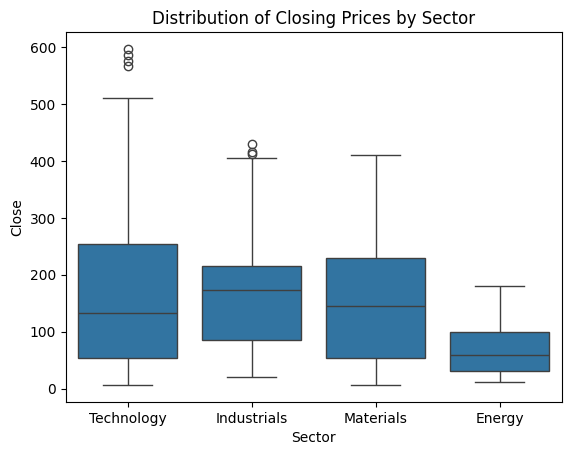

In [28]:
sns.boxplot(data=final_merged_df, x='Sector', y='Close')
plt.title("Distribution of Closing Prices by Sector")
plt.show()

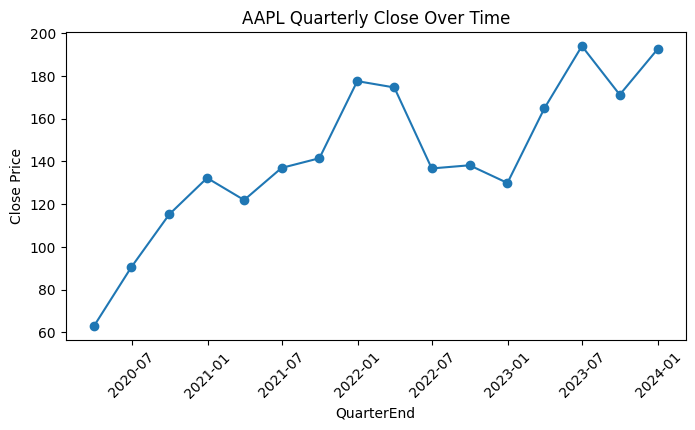

In [29]:
final_merged_df.sort_values(by=['Sector','Ticker','QuarterEnd'], inplace=True)

# Plotting a single ticker's price over time
ticker_choice = 'AAPL'  
df_ticker = final_merged_df[final_merged_df['Ticker'] == ticker_choice].copy()

plt.figure(figsize=(8,4))
plt.plot(df_ticker['QuarterEnd'], df_ticker['Close'], marker='o')
plt.title(f"{ticker_choice} Quarterly Close Over Time")
plt.xlabel("QuarterEnd")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.show()


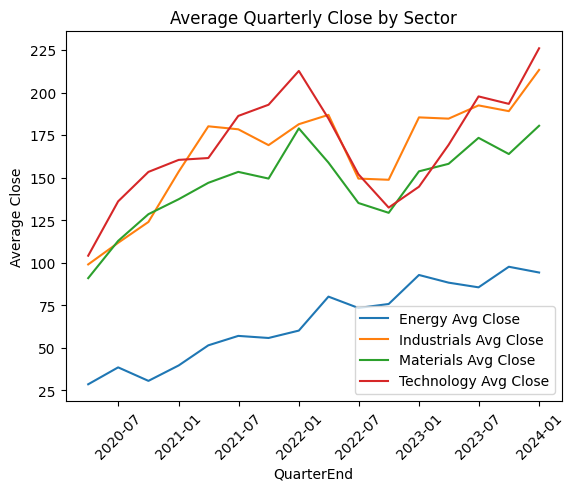

In [30]:
sector_qtr = (final_merged_df
    .groupby(['Sector','QuarterEnd'], as_index=False)
    .agg({'Close':'mean','GDP':'mean'})  # mean GDP is the same as the single GDP if aggregated, but you can do it
)

# Then plot a line chart
for sector_name in sector_qtr['Sector'].unique():
    sub = sector_qtr[sector_qtr['Sector'] == sector_name]
    plt.plot(sub['QuarterEnd'], sub['Close'], label=f"{sector_name} Avg Close")

plt.title("Average Quarterly Close by Sector")
plt.xlabel("QuarterEnd")
plt.ylabel("Average Close")
plt.legend()
plt.xticks(rotation=45)
plt.show()


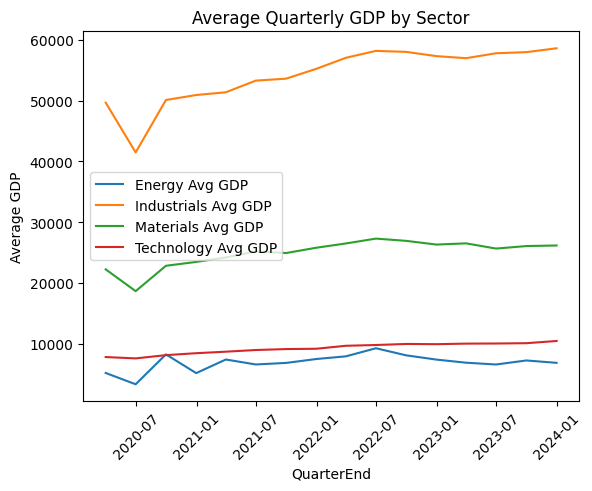

In [31]:
sector_qtr = (final_merged_df
    .groupby(['Sector','QuarterEnd'], as_index=False)
    .agg({'GDP':'mean'})  # mean GDP is the same as the single GDP if aggregated, but you can do it
)

# Then plot a line chart
for sector_name in sector_qtr['Sector'].unique():
    sub = sector_qtr[sector_qtr['Sector'] == sector_name]
    plt.plot(sub['QuarterEnd'], sub['GDP'], label=f"{sector_name} Avg GDP")

plt.title("Average Quarterly GDP by Sector")
plt.xlabel("QuarterEnd")
plt.ylabel("Average GDP")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Group final_merged_df by Sector, QuarterEnd, and compute mean GDP & mean Close
df_agg = (final_merged_df
          .groupby(['Sector','QuarterEnd'], as_index=False)
          .agg({
              'GDP': 'mean',    # or 'sum' or 'first' if each row is unique
              'Close': 'mean'   # or another price column
          }))

print(df_agg.head())


   Sector QuarterEnd       GDP      Close
0  Energy 2020-03-31  5203.999  28.580235
1  Energy 2020-06-30  3346.510  38.512501
2  Energy 2020-09-30  8263.417  30.579510
3  Energy 2020-12-31  5184.351  39.653630
4  Energy 2021-03-31  7421.190  51.467457


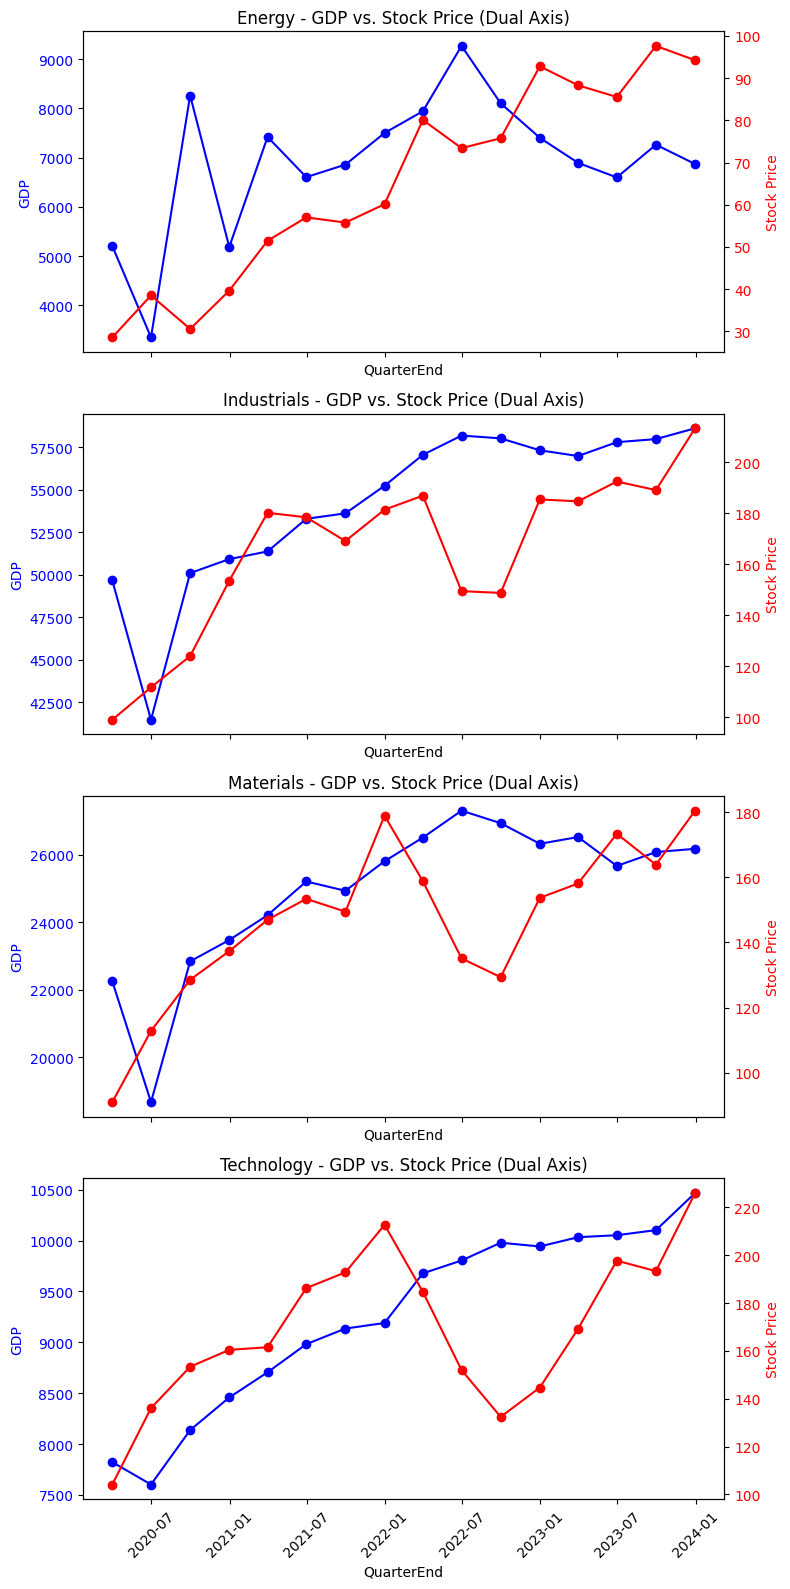

In [55]:
sectors = df_agg['Sector'].unique()
fig, axes = plt.subplots(nrows=len(sectors), ncols=1, figsize=(8, 4*len(sectors)), sharex=True)

if len(sectors) == 1:
    axes = [axes]

for ax, sector_name in zip(axes, sectors):
    sub = df_agg[df_agg['Sector'] == sector_name].sort_values('QuarterEnd')

    # Left axis: GDP
    ax.plot(sub['QuarterEnd'], sub['GDP'], color='blue', marker='o', label='GDP')
    ax.set_ylabel("GDP", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Create a second axis sharing the same x
    ax2 = ax.twinx()
    ax2.plot(sub['QuarterEnd'], sub['Close'], color='red', marker='o', label='Avg Price')
    ax2.set_ylabel("Stock Price", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_title(f"{sector_name} - GDP vs. Stock Price (Dual Axis)")
    ax.set_xlabel("QuarterEnd")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


              Close    Volume  Dividends    Weight       GDP
Close      1.000000 -0.205382  -0.026989  0.062916  0.216540
Volume    -0.205382  1.000000  -0.105343  0.259384 -0.161984
Dividends -0.026989 -0.105343   1.000000  0.059444 -0.064134
Weight     0.062916  0.259384   0.059444  1.000000 -0.256848
GDP        0.216540 -0.161984  -0.064134 -0.256848  1.000000


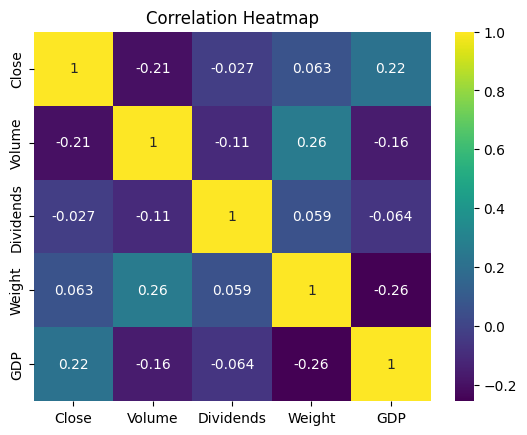

In [32]:
corr_cols = ['Close','Volume','Dividends','Weight','GDP']
corr_matrix = final_merged_df[corr_cols].corr()
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()


In [33]:
for sector_name in final_merged_df['Sector'].unique():
    sub = final_merged_df[final_merged_df['Sector'] == sector_name]
    corr_val = sub['Close'].corr(sub['GDP'])
    print(f"Correlation between Close and GDP in {sector_name}: {corr_val}")


Correlation between Close and GDP in Energy: 0.23687592634846402
Correlation between Close and GDP in Industrials: 0.2425548067025773
Correlation between Close and GDP in Materials: 0.14662613020584875
Correlation between Close and GDP in Technology: 0.12207353724196392


In [35]:
# 1) Sort your DataFrame so groupby shifts occur in the correct chronological order
final_merged_df = final_merged_df.sort_values(by=['Sector', 'QuarterEnd'])

# Ensure 'Pct_Return' column is created
final_merged_df['Pct_Return'] = final_merged_df.groupby('Ticker')['Close'].pct_change()

# 2) Compute quarter-over-quarter GDP growth per sector
#    pct_change() calculates (current - previous) / previous
final_merged_df['GDP_growth'] = final_merged_df.groupby('Sector')['GDP'].pct_change()

# 3) Create a lag of 1 quarter for GDP growth
final_merged_df['GDP_growth_lag1'] = final_merged_df.groupby('Sector')['GDP_growth'].shift(1)

# 4) For each sector, run OLS with Pct_Return as the dependent variable
#    and last quarter's GDP growth as the predictor
sectors = final_merged_df['Sector'].unique()
for sector_name in sectors:
    # Filter to that sector, drop rows with NaN in either Pct_Return or GDP_growth_lag1
    sub_df = final_merged_df[(final_merged_df['Sector'] == sector_name) & 
                      (~final_merged_df['Pct_Return'].isna()) & 
                      (~final_merged_df['GDP_growth_lag1'].isna())]
    
    # Check we have enough data
    if len(sub_df) > 2:
        model = smf.ols("Pct_Return ~ GDP_growth_lag1", data=sub_df).fit()
        print(f"\n=== Sector: {sector_name} ===")
        print(model.summary())
    else:
        print(f"\n=== Sector: {sector_name} ===")
        print("Not enough data points after dropping NaNs.")


=== Sector: Energy ===
                            OLS Regression Results                            
Dep. Variable:             Pct_Return   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.751
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.188
Time:                        00:07:13   Log-Likelihood:                 39.886
No. Observations:                 150   AIC:                            -75.77
Df Residuals:                     148   BIC:                            -69.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         

In [36]:
final_merged_df = final_merged_df.sort_values(by=['Ticker','QuarterEnd'])
final_merged_df['Pct_Return'] = final_merged_df.groupby('Ticker')['Close'].pct_change()


In [39]:
final_merged_df['GDP_scaled'] = final_merged_df['GDP'] / 1000_000  # e.g., in billions
model_df = final_merged_df.dropna(subset=['Pct_Return','GDP_growth_lag1'])
result = smf.ols("Pct_Return ~ GDP_growth_lag1", data=model_df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             Pct_Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.549
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.111
Time:                        00:08:21   Log-Likelihood:                 173.92
No. Observations:                 600   AIC:                            -343.8
Df Residuals:                     598   BIC:                            -335.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0792      0.007     

In [41]:
for sector_name in model_df['Sector'].unique():
    sub = model_df[model_df['Sector'] == sector_name]
    if len(sub) > 10:  # need enough data points
        reg_res = smf.ols("Pct_Return ~ GDP_growth_lag1", data=sub).fit()
        print(f"\n=== Sector: {sector_name} ===")
        print(reg_res.summary())



=== Sector: Technology ===
                            OLS Regression Results                            
Dep. Variable:             Pct_Return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.155
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.284
Time:                        00:08:35   Log-Likelihood:                 37.920
No. Observations:                 150   AIC:                            -71.84
Df Residuals:                     148   BIC:                            -65.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept     

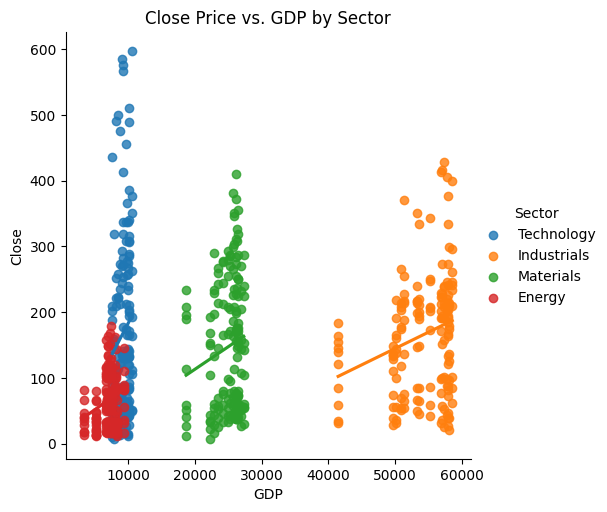

In [43]:
sns.lmplot(data=final_merged_df, x='GDP', y='Close', hue='Sector', ci=None)
plt.title("Close Price vs. GDP by Sector")
plt.show()


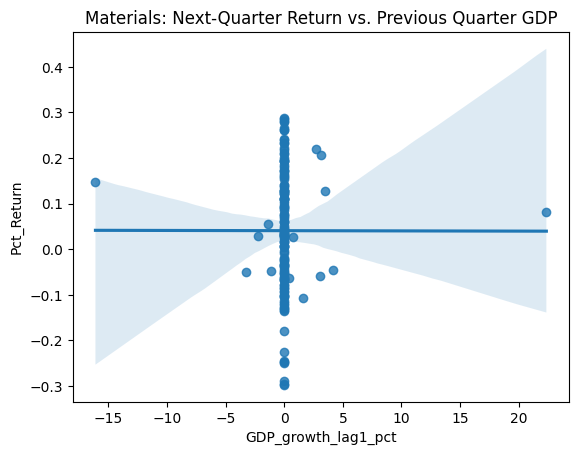

In [49]:
df_mat = final_merged_df[final_merged_df['Sector'] == 'Materials'].dropna(subset=['Pct_Return','GDP_growth_lag1'])
df_mat = df_mat[(df_mat['Pct_Return'] > -0.3) & (df_mat['Pct_Return'] < 0.3)]
df_mat['GDP_growth_lag1_pct'] = df_mat['GDP_growth_lag1'] * 100
sns.regplot(data=df_mat, x='GDP_growth_lag1_pct', y='Pct_Return')
plt.title("Materials: Next-Quarter Return vs. Previous Quarter GDP")
plt.show()

In [50]:
# Scale GDP from e.g. millions to billions
final_merged_df['GDP_bln'] = final_merged_df['GDP'] / 1e3

# Re-run the regression but replace GDP_lag1 with scaled version
final_merged_df['GDP_bln_lag1'] = final_merged_df.groupby('Sector')['GDP_bln'].shift(1)

model_mat_bln = smf.ols("Pct_Return ~ GDP_bln_lag1", data=final_merged_df[final_merged_df['Sector'] == 'Materials']).fit()
print(model_mat_bln.summary())

                            OLS Regression Results                            
Dep. Variable:             Pct_Return   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     19.84
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.65e-05
Time:                        00:12:42   Log-Likelihood:                 57.937
No. Observations:                 150   AIC:                            -111.9
Df Residuals:                     148   BIC:                            -105.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7485      0.153      4.888   

In [51]:
final_merged_df = final_merged_df.sort_values(by=['Sector','QuarterEnd'])
final_merged_df['GDP_growth'] = final_merged_df.groupby('Sector')['GDP'].pct_change()
final_merged_df['GDP_growth_lag1'] = final_merged_df.groupby('Sector')['GDP_growth'].shift(1)

model_mat_growth = smf.ols("Pct_Return ~ GDP_growth_lag1", data=final_merged_df[final_merged_df['Sector'] == 'Materials']).fit()
print(model_mat_growth.summary())

                            OLS Regression Results                            
Dep. Variable:             Pct_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.002097
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.964
Time:                        00:12:45   Log-Likelihood:                 48.504
No. Observations:                 150   AIC:                            -93.01
Df Residuals:                     148   BIC:                            -86.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0691      0.014     

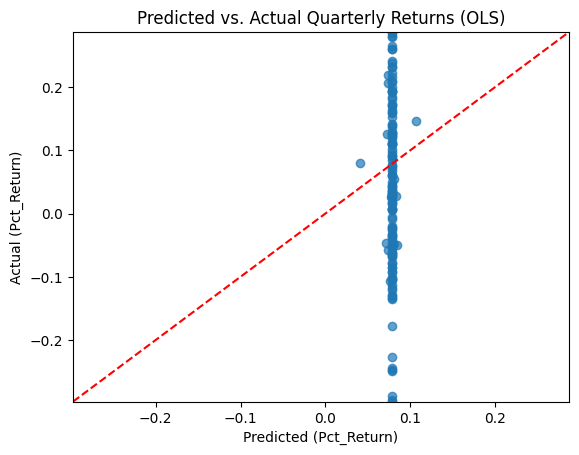

In [52]:
import matplotlib.pyplot as plt

# 1) Extract the features used in your model
X = df_mat[['GDP_growth_lag1']]  # or however you constructed your design matrix

# 2) True target values
y = df_mat['Pct_Return']

# 3) Predicted values from the model
y_pred = result.predict(X)

# 4) Plot predicted vs. actual
plt.scatter(y_pred, y, alpha=0.7)
plt.xlabel("Predicted (Pct_Return)")
plt.ylabel("Actual (Pct_Return)")
plt.title("Predicted vs. Actual Quarterly Returns (OLS)")

# Optionally add a diagonal line of perfect prediction
lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')  # dashed red diagonal
plt.xlim(lims)
plt.ylim(lims)

plt.show()


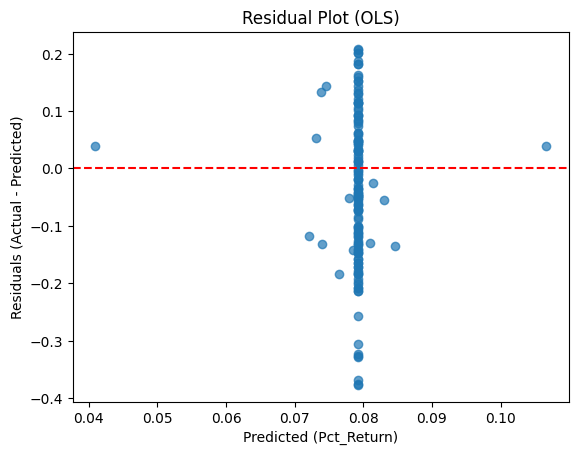

In [53]:
residuals = y - y_pred

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # zero-residual line
plt.xlabel("Predicted (Pct_Return)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (OLS)")

plt.show()
